<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/NLPModel_MultiLabel_LogisticRegression_Word2VecTextVectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Model with Word2Vec and Logistic Regression

In this notebook, we are going to use a Logistic Regression Model to predict categories of text. Logistic regression is a simple and easy to understand classification algorithm, and Logistic regression can be easily generalized to multiple classes. To vectorize the text we are going to use the Word2Vec. Word2vec is a type of mapping that allows words with similar meaning to have similar vector representation. 

In this case, we convert each word to its Word2Vec representation (vector of 300 features). Then, for each text, we calculate a only vector representation (of 300 features). For this, we get the average of all the text word embeddings.

Word2Vect: https://code.google.com/archive/p/word2vec/

Notebook adapted from: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568



In [0]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Data

### Fetch data

We are using a relatively large data set of Stack Overflow questions and tags.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
categories = df["tags"].unique()

print(f'Number of examples : {len(df)}')
print(f'Number of words in the data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')
print(f'Number of categorie : {len(categories)}')
print()
print(df.head(10))
print()
print(f'Categories: {categories}')


Number of examples : 40000
Number of words in the data: 10286120
Number of categorie : 20

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs

Categories: ['c#' 'asp.net' 'objective-c' '.net' 'python' 'angularjs' 'iphone'
 'ruby-on-rails' 'ios' 'c' 'sql' 'java' 'jquery' 'css' 'c++' 'php'
 'android' 'my

Visualize data

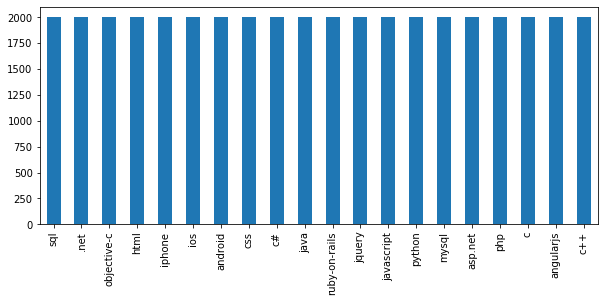

In [4]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

### Text pre-processing

Our text cleaning step includes HTML decoding, remove stop words, change text to lower case, remove punctuation, remove bad characters, and so on.

In [5]:
 nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

print(f'Example text previous cleaning : {df["post"].values[10]}')

df['post'] = df['post'].apply(clean_text)

print(f'Example text previous cleaning : {df["post"].values[10]}')

Example text previous cleaning : when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interf

In [7]:
print(f'Number of words in the cleaning data: {df["post"].apply(lambda x: len(x.split(" "))).sum()}')

Number of words in the cleaning data: 3424297


## Model training

First we load a word2vec model. It has been pre-trained by Google on a 100 billion word Google News corpus.

### Word2Vec

* **Fetch Word2Vec model**

First we load a word2vec model. It has been pre-trained by Google on a 100 billion word Google News corpus.

In [0]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
wv.init_sims(replace=True)

Visualize some vocabulary to know what is in the corpus

In [9]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

We can access to the index of one word in the Word2Vec vocabulary

In [17]:
wv.vocab["Memorial_Hospital"].index

13030

We can obtain the Word2Vec embedding for one specific word

In [20]:
wembedding = wv.syn0norm[wv.vocab["Memorial_Hospital"].index]
print(f'Word2Vec vectorize each word in a vector of shape : {wembedding.shape}')

Word2Vec vectorize each word in a vector of shape : (300,)


* **Prepare data**

We split the data to train and evaluation examples

In [10]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

print(f'Number of training examples: {len(train)}')
print(f'Number of training examples: {len(test)}')

Number of training examples: 28000
Number of training examples: 12000


* **Tokenize text**

We apply the tokenization to “post” column

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
print(f"Example text pre-tokenization : {train['post'].values[0]}")

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

print(f"Example text post-tokenization : {train_tokenized[0]}")

Example text pre-tokenization : getting server tag well formed error th style width200px aspcheckbox id utilitychanged # eval id runat server enabled true onchange utilitychanged # eval id checked # converttoboolean eval checked th error server tag well formedi cant seem debug itany help guys edit commented ochange still getting error directly code binding different field using datasource works fine th style width200px # eval name th doesnt work th style width200px aspcheckbox id utilitychanged# eval id runat server enabled true checked # converttoboolean eval checked th
Example text post-tokenization : ['getting', 'server', 'tag', 'well', 'formed', 'error', 'th', 'style', 'width200px', 'aspcheckbox', 'id', 'utilitychanged', 'eval', 'id', 'runat', 'server', 'enabled', 'true', 'onchange', 'utilitychanged', 'eval', 'id', 'checked', 'converttoboolean', 'eval', 'checked', 'th', 'error', 'server', 'tag', 'well', 'formedi', 'cant', 'seem', 'debug', 'itany', 'help', 'guys', 'edit', 'commented

* **Word Embedding using Word2Vec**

BOW based approaches that includes averaging, summation, weighted addition. The common way is to average the two word vectors. Therefore, we will follow the most common way.

Really, in this code we are vectorization each text in one only vector taking the average of each word vector in each text.

In [0]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            # Store the word embedding in W2V
            mean.append(wv.syn0norm[wv.vocab[word].index])
            # Store the word index in the W2V vocabulary
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [34]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

### Logistic Regression Model

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)

We train the vectorizers and model

In [36]:
%%time
logreg = logreg.fit(X_train_word_average, train['tags'])

CPU times: user 1min 41s, sys: 30.3 ms, total: 1min 41s
Wall time: 1min 41s


## Model evaluation

In [38]:
%%time
from sklearn.metrics import classification_report
y_pred = logreg.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=categories))

accuracy 0.6380833333333333
               precision    recall  f1-score   support

           c#       0.63      0.59      0.61       613
      asp.net       0.74      0.76      0.75       620
  objective-c       0.65      0.67      0.66       587
         .net       0.53      0.52      0.52       586
       python       0.70      0.77      0.73       599
    angularjs       0.44      0.39      0.41       589
       iphone       0.65      0.60      0.63       594
ruby-on-rails       0.73      0.80      0.76       610
          ios       0.61      0.61      0.61       617
            c       0.56      0.52      0.54       587
          sql       0.55      0.50      0.52       611
         java       0.61      0.61      0.61       594
       jquery       0.65      0.65      0.65       619
          css       0.61      0.57      0.59       574
          c++       0.70      0.71      0.70       584
          php       0.43      0.43      0.43       578
      android       0.68      0.71  